### Importing Libraries

In [1]:
import torch
import numpy as np
import pandas as pd 
from transformers import AutoTokenizer
from datasets import load_dataset 
import datasets
import random
import matplotlib.pyplot as plt


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


### Helper Function to Show Random Elements of Datasets

In [2]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    pd.set_option('display.max_colwidth', None)
    return df

In [3]:
### Tokenizer to preprocess the input before feeding into the model
seq_len = 128
model_checkpoint = 'bert-base-uncased'

### Define tokenizer to be used for tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

## Loading SST2 Dataset

In [4]:
### Reference: https://huggingface.co/datasets/glue
task = "sst2"
dataset = load_dataset("glue", task)
dataset

Found cached dataset glue (/home/weiming/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [5]:
print(f"# of Train Sequences: {len(dataset['train'])},\
        # of Validation Sequences: {len(dataset['validation'])}")

# of Train Sequences: 67349,        # of Validation Sequences: 872


In [6]:
show_random_elements(dataset["train"], 10)

,sentence,label,idx
0,william james once called ` the gift of tears,positive,21158
1,"director hoffman , with great help from kevin kline",positive,14637
2,"a photographic marvel of sorts , and it 's certainly an invaluable record of that special fishy community .",positive,67100
3,long-on-the-shelf,negative,59807
4,"philippe , who makes oliver far more interesting than the character 's lines would suggest",positive,26596
5,the full monty was a freshman fluke,negative,42152
6,keeping the balance between the fantastic and the believable,positive,43961
7,at a time when commercialism has squeezed the life out of whatever idealism american moviemaking ever had,negative,12114
8,he 's the best brush in the business,positive,41139
9,a real audience-pleaser that will strike a chord with anyone who 's ever,positive,41600


In [7]:
show_random_elements(dataset["validation"], 10)

,sentence,label,idx
0,serving sara does n't serve up a whole lot of laughs .,negative,298
1,"displaying about equal amounts of naiveté , passion and talent , beneath clouds establishes sen as a filmmaker of considerable potential .",positive,359
2,"miller is playing so free with emotions , and the fact that children are hostages to fortune , that he makes the audience hostage to his swaggering affectation of seriousness .",positive,850
3,this is so bad .,negative,493
4,this movie seems to have been written using mad-libs .,negative,229
5,"against all odds in heaven and hell , it creeped me out just fine .",positive,614
6,i 'm just too bored to care .,negative,419
7,"add yet another hat to a talented head , clooney 's a good director .",positive,859
8,the film makes a fatal mistake : it asks us to care about a young man whose only apparent virtue is that he is not quite as unpleasant as some of the people in his life .,negative,786
9,"there ought to be a directing license , so that ed burns can have his revoked .",negative,202


Not much cleaning is required on the SST2 dataset given that the data itself is already quite clean. 

Min Seq Length (Train): 2
Max Seq Length (Train): 53
Min Seq Length (Validation): 3
Max Seq Length (Validation): 48


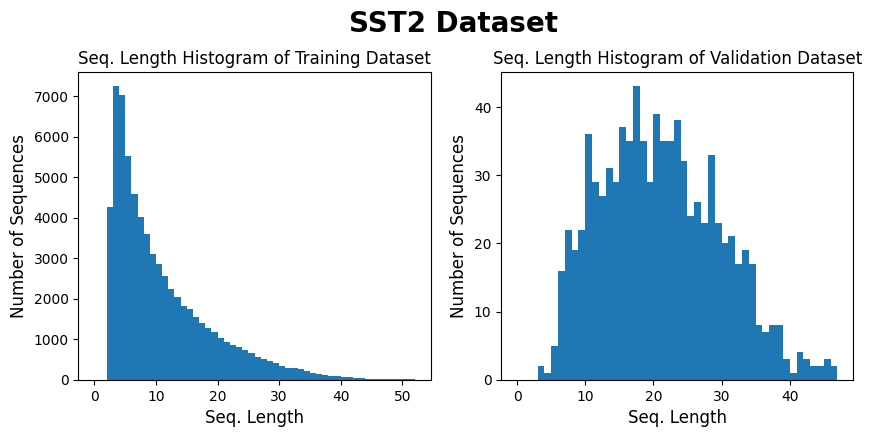

In [8]:
list_of_seq_len_train = []
list_of_seq_len_val = []
for seq in dataset["train"]["sentence"]:
    # For each sequence, count how many words are there
    list_of_seq_len_train.append(len(seq.split(" ")))

for seq in dataset["validation"]["sentence"]:
    # For each sequence, count how many words are there
    list_of_seq_len_val.append(len(seq.split(" ")))
    
print(f"\
Min Seq Length (Train): {min(list_of_seq_len_train)}\n\
Max Seq Length (Train): {max(list_of_seq_len_train)}\n\
Min Seq Length (Validation): {min(list_of_seq_len_val)}\n\
Max Seq Length (Validation): {max(list_of_seq_len_val)}\
")

bins_train = np.arange(0, max(list_of_seq_len_train))
seq_len_hist_train, bins_train = np.histogram(list_of_seq_len_train, bins_train)

bins_val = np.arange(0, max(list_of_seq_len_val))
seq_len_hist_val, bins_val = np.histogram(list_of_seq_len_val, bins_val)

fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))
plt.text(x=0.5, y=0.98, s=f"SST2 Dataset", fontsize=20, ha="center", weight="bold", transform=fig.transFigure)
font_size_1 = 12
ax[0].stairs(seq_len_hist_train, bins_train, fill=True)
ax[0].set_xlabel("Seq. Length", fontsize=font_size_1)
ax[0].set_ylabel("Number of Sequences", fontsize=font_size_1)
ax[0].set_title("Seq. Length Histogram of Training Dataset", fontsize=font_size_1)

ax[1].stairs(seq_len_hist_val, bins_val, fill=True)
ax[1].set_xlabel("Seq. Length", fontsize=font_size_1)
ax[1].set_ylabel("Number of Sequences",fontsize=font_size_1)
ax[1].set_title("Seq. Length Histogram of Validation Dataset",fontsize=font_size_1)
plt.show()

Maximum Sequence of Training Dataset: ***53*** <br>
Maximum Sequence of Validation Dataset: ***48***

From the above histogram plots, we can see that that most of the sequences in the training dataset have sequence length ***less than 20*** while most of the sequences in the validation dataset have sequence length of ***between 5 and 35***.

For simplicity, we will round up the sequence length to the nearest multiple of 2, which is ***64*** in this case. A sequence length longer than what is observed in the training and validation datasets is used in the event that real-time inference contains input with longer sequence length. 

In [9]:
seq_len = 64
# Preprocessing the data - converting words into vectors using tokenizers
def preprocess_function(examples):
    return tokenizer(examples["sentence"],  max_length=seq_len, padding = "max_length", truncation=True,)

encoded_dataset = dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-c9d9f2bc1b59381a.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-cf9cd8df5503064c.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

The SST2 data is now ready for training the model. <br>
**Training Dataset:** ```encoded_dataset['train']``` <br>
**Validation Dataset:** ```encoded_dataset['validation']```

### Checking the Mapping of Labels for SST2 Training and Validation Dataset
Class label 0 denotes negative senitment while class label 1 denotes positive sentiment.

In [10]:
print("Mapping of Labels for Training Dataset")
for i in range(dataset['train'].features['label'].num_classes):
    print(f"{i}: {dataset['train'].features['label'].int2str(i)}")

print()

print("Mapping of Labels for Validation Dataset")
for i in range(dataset['test'].features['label'].num_classes):
    print(f"{i}: {dataset['test'].features['label'].int2str(i)}")
    

Mapping of Labels for Training Dataset
0: negative
1: positive

Mapping of Labels for Validation Dataset
0: negative
1: positive


## Loading IMDb Dataset

In [11]:
### Loading IMDb Dataset from HuggingFace
### https://huggingface.co/datasets/imdb
dataset = load_dataset("imdb")
dataset

Found cached dataset imdb (/home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [12]:
print(f"# of Train Sequences: {len(dataset['train'])},\
        # of Validation Sequences: {len(dataset['test'])}")

# of Train Sequences: 25000,        # of Validation Sequences: 25000


In [13]:
show_random_elements(dataset["train"], 10)

,text,label
0,"Saw this movie when it came out in 1959, left a lasting impression. Great group of actors. A little short timewise but a great movie all the same. Have only seen once since then and that was some time ago. Hopefully they'll put it out on DVD if they haven't already.",pos
1,This movie is one of the best ever produced by disney.<br /><br />The plot is very original and entertaining. The animated sequence is also very well done with the live actors. (For the time).<br /><br />Perhaps one of my favorite sequences is contained in this movie with the march of the suits of armor.,pos
2,"An anthology is always risky business and I think this endeavor should be praised. There's a lot of talent involved here. A great many talented actors, directors and writers. Unfortunately, I couldn't really enjoy this movie based on three issues I had.<br /><br />First of all, the segments vary incredibly in tone and quality. And unfortunately some of them clash with the others. <br /><br />Secondly, several segments feel underdeveloped to me. Like seeds of good stories that never come to fruition. I'm not talking about happy endings here (or even an ending period) but rather, they lack even basic development or even solid setups that draw you in. <br /><br />Last but not least, I did not feel New-York and its inhabitants were properly portrayed.<br /><br />What you're left with is high-brow short films that may still be of interest to some but will leave the average viewer unsatisfied.",neg
3,"A sweet-natured young mountain man with a sad past (Henry Thomas) comes upon an abandoned baby girl in the woods and instantly falls in love with her. The town elders generally support him in keeping the child, though a local temptress (Cara Seymour) thinks little of the new family. A determined little girl on a long walk and a sinister travelling salesman (David Strathairn at his creepiest) have parallel stories which converge in a fateful way. This is a charming slice-of-life in the Ozarks in the same vein as ""Where The Lillies Bloom"" & ""The Dollmaker"". All three were shot on location in those beautiful hills and cover the lives of simple-living -- but not simple-minded -- American folk. A minimum of strong language and brief but pointed violence make this fairly-safe family viewing.",pos
4,"I disagree with Anyone who done't like this movie. <br /><br />I used to LOVE this movie when I was little and I still do. It's sweet, funny and warms your heart. And It proves that love and friendship can never be destroyed. <br /><br />And even though it didn't have much of a story, it was still excellent I give it a 10 and two thumbs up. <br /><br />Oh yeah and it proves that your deepest wish's and dreams can come true. (Tear, tear)<br /><br />I love this movie, personally if anyone says it sucked than I will say ""Shame on you."" Because it was a delightful little movie and I'm glad that at least SOME people liked it.",pos
5,"This sad little film bears little similarity to the 1971 Broadway revival that was such a 'nostalgic' hit. Keep in mind that when Burt Shevelove directed that revival, he rewrote the book extensively. I have a feeling that this screenwriter wrought as much of a change from the original 1925 version as well. I played the 'innocent philanderer' Jimmy Smith on-stage in 1974, and thought this $1 DVD would bring back memories. Not a chance. Even the anticipated delight of seeing ""Topper"" Roland Young play 'my' part was a major disappointment. Three songs from the play remain, and are done very poorly. Even the classic duet, ""Tea For Two"", is done as a virtual solo. The many familiar faces in this 1940 fiasco do not do themselves proud at all, and the star, Anna Neagle, just embarrasses herself. When I feel gypped by spending a dollar, I know the film must be bad. Another commentator mentioned the Doris Day version, which is actually called ""Tea For Two"" and is about doing the stage play (the original, of course), so those wh

In [14]:
show_random_elements(dataset["test"], 10)

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

A quick inspection of the IMDb dataset show that several sentences contains ```<br /><br />``` which does not help in classification at all. Hence, we should remove it.

**Example:** Awful, awful, awful.```<br /><br />```A condescending remark at the start and a few nasty autopsy photos does not a good movie make. Once again I'm amazed at the determination and skill that some people have in achieving a movie production and yet they don't have the pride to realise that what they have made is an utter pile of crap.```<br /><br />```I sat and tried to think of a redeeming feature so that I could at least balance my criticism but the only one I could think of was that the opening track by Pink was pretty good....I wonder if she has seen this?```<br /><br />```Watch this at your peril, the boredom may kill you.

### Data Cleaning and Preprocessing

In [15]:
### Removing <br /><br /> from the dataset
def preprocess_function_1(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('<br /><br />', " ")
    return examples

### Tokenizing words into integer for embedding layer in BERT
seq_len = 128
def preprocess_function_2(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)

In [16]:
### Preprocess all data loaded for the IMDB task
dataset = dataset.map(preprocess_function_1, batched=True)
encoded_dataset = dataset.map(preprocess_function_2, batched=True)

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-d148e977a62f295c.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-44e7f026ff7a0635.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-160673d1d2e0b363.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-00a99835f544b425.arrow


  0%|          | 0/25 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-e332a04470700392.arrow


The IMDb data is now ready for training the model. <br>
**Training Dataset:** ```encoded_dataset['train']``` <br>
**Validation Dataset:** ```encoded_dataset['test']```

### Checking the Mapping of Labels for IMDb Training and Validation Dataset
Class label 0 denotes negative senitment while class label 1 denotes positive sentiment.

In [17]:
print("Mapping of Labels for Training Dataset")
for i in range(dataset['train'].features['label'].num_classes):
    print(f"{i}: {dataset['train'].features['label'].int2str(i)}")

print()

print("Mapping of Labels for Validation Dataset")
for i in range(dataset['test'].features['label'].num_classes):
    print(f"{i}: {dataset['test'].features['label'].int2str(i)}")
    

Mapping of Labels for Training Dataset
0: neg
1: pos

Mapping of Labels for Validation Dataset
0: neg
1: pos


### Plotting Sequence Length Distribution of IMDb Training and Validation Datasets

Min Seq Length (Train): 10
Max Seq Length (Train): 2460
Min Seq Length (Validation): 4
Max Seq Length (Validation): 2235


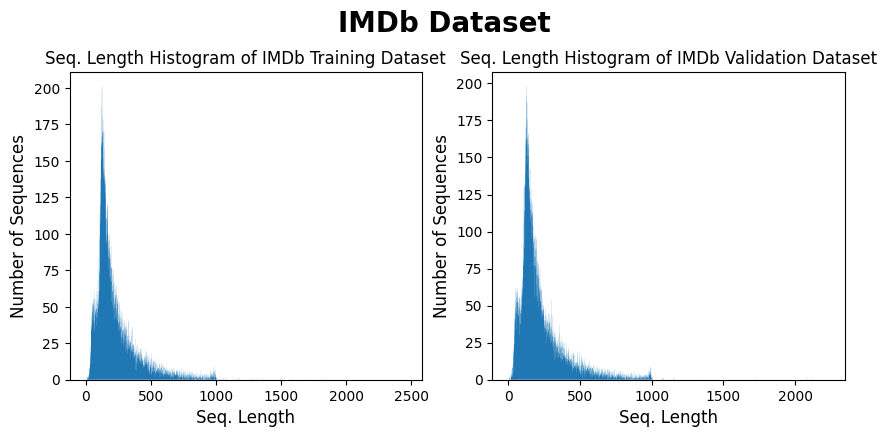

In [19]:
list_of_seq_len_train = []
list_of_seq_len_val = []
for seq in dataset["train"]["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_train.append(len(seq.split(" ")))

for seq in dataset["test"]["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_val.append(len(seq.split(" ")))

print(f"\
Min Seq Length (Train): {min(list_of_seq_len_train)}\n\
Max Seq Length (Train): {max(list_of_seq_len_train)}\n\
Min Seq Length (Validation): {min(list_of_seq_len_val)}\n\
Max Seq Length (Validation): {max(list_of_seq_len_val)}\
")

bins_train = np.arange(0, max(list_of_seq_len_train))
seq_len_hist_train, bins_train = np.histogram(list_of_seq_len_train, bins_train)

bins_val = np.arange(0, max(list_of_seq_len_val))
seq_len_hist_val, bins_val = np.histogram(list_of_seq_len_val, bins_val)

fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))
plt.text(x=0.5, y=0.98, s=f"IMDb Dataset", fontsize=20, ha="center", weight="bold", transform=fig.transFigure)
font_size_1 = 12
ax[0].stairs(seq_len_hist_train, bins_train, fill=True)
ax[0].set_xlabel("Seq. Length", fontsize = font_size_1)
ax[0].set_ylabel("Number of Sequences", fontsize = font_size_1)
ax[0].set_title("Seq. Length Histogram of IMDb Training Dataset", fontsize = font_size_1)

ax[1].stairs(seq_len_hist_val, bins_val, fill=True)
ax[1].set_xlabel("Seq. Length", fontsize = font_size_1)
ax[1].set_ylabel("Number of Sequences", fontsize = font_size_1)
ax[1].set_title("Seq. Length Histogram of IMDb Validation Dataset", fontsize = font_size_1)
plt.show()

Maximum Sequence of Training Dataset: ***2460*** <br>
Maximum Sequence of Validation Dataset: ***2235***

From the above histogram plots, we can see that that most of the sequences in the training and validation datasets have sequence length beyond 128 words.

However, for the sake of faster finetuning time, we will use an input sequence length of **128**

## Loading Yelp Review Dataset

In [20]:
### Loading Yelp Dataset from HuggingFace
### https://huggingface.co/datasets/yelp_review_full
dataset = load_dataset('yelp_review_full')
dataset

Found cached dataset yelp_review_full (/home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [21]:
print(f"# of Train Sequences: {len(dataset['train'])},\
        # of Validation Sequences: {len(dataset['test'])}")

# of Train Sequences: 650000,        # of Validation Sequences: 50000


In [22]:
show_random_elements(dataset["train"], 10)

,label,text
0,3 stars,"Ok it wasn't great but it wasn't all bad either. I had the Connecticut roll with Cajun fries. The roll itself I have definitely had better, it was lacking that warm buttery flavor. The good thing is that it was stuffed with plenty of lobster. The Cajun fries were pretty good. Customer service was great, nice and friendly and very helpful. I might give them another chance and maybe try Mac and cheese or grilled cheese next time I'm in Vegas, maybe they can redeem themselves."
1,4 stars,"I really liked this toy shop! It has a ton of unique toy figurines and other memorabilia. It was a walk down memory lane seeing the Holiday Barbie's, while my husband was drooling over the Transformers case! \n \nI don't typically watch the Pawn Stars show. Apparently, the owners of the Toy Shack are connected to the Pawn Stars and they do the toy appraisals for the show. We talked to one of the owners. He explained how to make an appointment to bring items down we are interested in selling. At this point, because of being newly opened and the hype of the Pawn Stars show, they are only doing appraisals on Monday mornings. He said to call and make an appointment. \n\nHe also told us a story about a customer who didn't know the value of the items she had and was trying to sell them. Immediately they realized what she had and they ended up contacting her father. Long story short, they saved the family doll collection from being sold. These guys seem like they are in business for the right reasons and aren't out to screw anyone over.\n \nMy husband and I both plan on bringing a couple items in. It's definitely worth checking out if you're Downtown....lots of cool stuff to see!\n\n***On another positive note, the Neonopolis is going to be opening more shops! I was so happy to hear there is a revitalization of this area! It'll be exciting to see the changes in the next couple months."
2,1 star,"Wow! I thought this looked really nice from the outside. When I saw the menu and was served a fresh pappadum, I was reassured. BUT, to my surprise, the service, food and management was incredibly poor. Ok, it was Sat. and very crowded, probably the reason we didn't get anything we ordered for 45 minutes...fine. When the food came. 2 main dishes weren't even put into the kitchen and two of us waited another 15 minutes. Ok, if the food was great, I would've let it go but not only was it over salted, under spiced, and un-authentic, the portions were a total joke!! I ended complaining to the manager and sarcastically he said it was our fault because we didn't have reservations...? He also said since I was a big guy, I was asking for larger portions...and we're lucky he let us eat there without reservations. Bottom line, this was truly one of the overall worst meals ever, and I've been to tons of Indian places...this was firstly a Bangladeshi joint hiding behind an Indian disguise, which happens a lot but doesn't show in the food quite like this did. Insulting to the taste buds and added I jury because the prices are up there."
3,2 star,"According to the phone book there are currently 6 locations of this local chain. This location started life as a Taco Bell and has been several Mexican fast food places since then. The building has seen a lot of wear. \n\nThey have quite a wide menu including mini soft tacos for $.99. I got my usual test platter of a shredded beef taco and a cheese enchilada ($6.50) and a medium Horchata ($2.00). The taco was both greasy and tasty, the two seem to go hand in hand. The cheese enchilada came on a corn tortilla and was light on the cheese. I didn't care for their choice of enchilada sauce. The beans and rice were ok, the rice had mixed vegetables in it. The overall serving size was quite ample. The Horchata was one of the better ones I have had.\n\nServing the eat in orders on real plates is a nice touch. But it leads to a problem as their is no way to clear your own table after the first two customers have and t

In [23]:
show_random_elements(dataset["test"], 10)

,label,text
0,4 stars,"MY FAVORITE Happy Hour (food) Menu!! The calamari, the bbq chicken pizza, the sushi rolls, and the sliders are the best choices! The Happy Hour prices are great too! Sometimes it does get pretty noisy, but it's a fun place to go to watch a game and hang out with friends. To be honest, I'm not a huge fan of the happy hour drink menu... Their cosmos make me sick, they're far too sweet, the wine doesn't ever seem like that good of a deal, nor do the saki bombs. But the food is great!!!"
1,2 star,"While there wasn't anything terrible about my dinner here, there wasn't anything terribly memorable either. I went for a date with my boyfriend on a Monday night after purchasing a Groupon. I enjoyed the stuffed mushrooms and my rotolini, and my boyfriend liked his veal. But nothing jumped out at us as amazing. Over all, we were very glad to have purchased the groupon, because otherwise we would have been very unhappy to pay the seriously over-priced bill. The service was about the same as the food....not terrible, but lackluster."
2,1 star,"I LOATHE this Bar and Grill! This place has provided the worst restaurant experience I have had in all of 2013!\n\nI went with a group of eight people for dinner on a Thursday night. Our waitress didn't seem to understand the difference between import and domestic beers. She made her way around the table taking drink orders, starting with me, then when she got back around she tried to take my drink order again! I calmly told her that I already gave it to her and she just shrugged it off. So after the drinks arrive she asks if we want to order appetizers. She starts taking appetizer orders, again starting with me and guess what? After going around the table she asks what I would like for my appetizer! Not a good sign. \n\nWhen she drops off our appetizers she tries taking our menus. Several members of our group told her that we wanted to order dinner. She said \""Ok\"" and promptly dashed off! This was another recurring theme with her- she was like the Houdini of wait staff- whenever someone needed a drink or sauce she vanish! \n\nNow for the food- The one thing that I enjoyed was the cornbread- it was light and not overly sweet. For my appetizer I ordered the fried mac & cheese and it was disappointingly dull. For dinner I ordered the Big bacon and Cheddar - a bacon cheeseburger. I asked for a side of mayo. What came out instead was Miracle Whip- which I can't stand. I don't care if they don't have mayo, but if they're going to try to pass off MW for mayo they shouldn't be in the food service industry. the burger itself was only ok. It was cooked to medium rare as ordered but I could have a much better burger with competent service just a few feet away at Blu Burger Grill. The only positive at this place is the happy hour pricing."
3,3 stars,Clean little taco shop normal selection of stuff.\n\nGoing with fish taco lunch special. I have had a hard time finding a really good fish taco in Vegas. So after trying the fish tacos I'm still searching. However the rice actually had some flavor and the beans tasted like they were made in house. The service was better than I need for a taco shop. I will give them another shot because I liked their rice and beans.
4,5 stars,The duck fat fried French fries come out to start and you know you're in a good place. We tried a few things off the main menu but the Rib cap is seriously the best thing I've ever had.
5,1 star,Every time I go here there is always something wrong with my order always check your food before you leave I guarantee you will always be missing something or something ain't right.
6,4 stars,"I'm still a member, but apparently this place has undergone a lot of changes since it first opened last year. There are only a handful of the original instructors, but I really enjoy the diversity and varied workouts that each teacher has to offer.\n\nAmong the instructors, they also have some new people like Todd, Vadim (reigning Muay Tha

A quick inspection of the Yelp Review dataset show that several sentences contains ```\\n``` and ```\\"``` which does not help in classification at all. Hence, we should remove it.

**Example:**: <br> ```dataset["train"]['text'][3]```: 'Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new position there in June.  He will be missed very much.  ```\\n\\n```I think finding a new doctor in NYC that you actually like might almost be as awful as trying to find a date!' <br>
```dataset["train"]['text'][6786]```: 'Arrived and waited for 10 minutes before I grabbed a menu and asked an employee if the guests were supposed to seat themselves.. He responded ```\\"``` You can```\\"``` and walked by with out furthering assisting me.'

In [24]:
### Removing '\\n' and replacing \\" with " from the dataset 
def preprocess_function_1(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('\\n', " ")
        examples['text'][i] = examples['text'][i].replace('\\"', '"')

    return examples

### Tokenizing words into integer for embedding layer in BERT
seq_len = 128
def preprocess_function_2(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)

In [25]:
dataset = dataset.map(preprocess_function_1, batched=True)
encoded_dataset = dataset.map(preprocess_function_2, batched=True)

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-f85dff166b9bf818.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-a8db05a023f4167a.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-f6ad4cddb041afc7.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-faa260cdc4d81134.arrow


The IMDb data is now ready for training the model. <br>
**Training Dataset:** ```encoded_dataset['train']``` <br>
**Validation Dataset:** ```encoded_dataset['test']```

### Checking the Mapping of Labels for Yelp Review Training and Validation Dataset
0 - ```1 star```, 1 - ```2 star```, 2 - ```3 stars```, 3 - ```4 stars```, 4 - ```5 stars```

This is a 5 class label classification task.

In [26]:
print("Mapping of Labels for Training Dataset")
for i in range(dataset['train'].features['label'].num_classes):
    print(f"{i}: {dataset['train'].features['label'].int2str(i)}")

print()

print("Mapping of Labels for Validation Dataset")
for i in range(dataset['test'].features['label'].num_classes):
    print(f"{i}: {dataset['test'].features['label'].int2str(i)}")
    

Mapping of Labels for Training Dataset
0: 1 star
1: 2 star
2: 3 stars
3: 4 stars
4: 5 stars

Mapping of Labels for Validation Dataset
0: 1 star
1: 2 star
2: 3 stars
3: 4 stars
4: 5 stars


### Plotting Sequence Length Distribution of Yelp Training and Validation Datasets

Min Seq Length (Train): 1
Max Seq Length (Train): 1102
Min Seq Length (Validation): 1
Max Seq Length (Validation): 1053


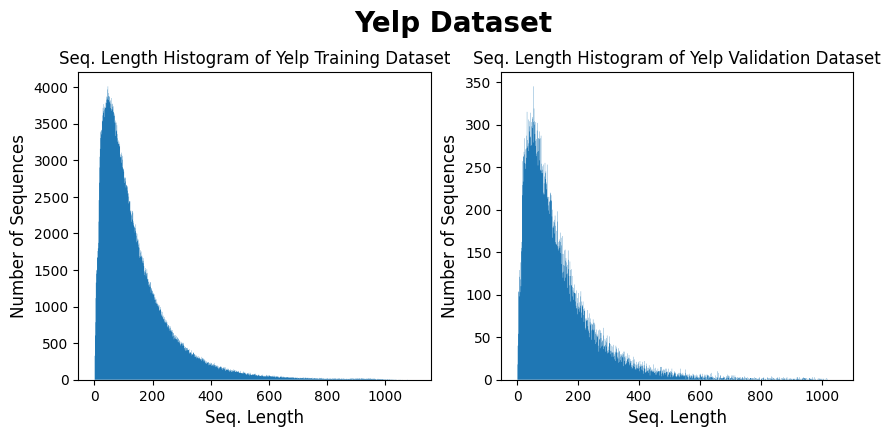

In [27]:
list_of_seq_len_train = []
list_of_seq_len_val = []
for seq in dataset["train"]["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_train.append(len(seq.split(" ")))

for seq in dataset["test"]["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_val.append(len(seq.split(" ")))

print(f"\
Min Seq Length (Train): {min(list_of_seq_len_train)}\n\
Max Seq Length (Train): {max(list_of_seq_len_train)}\n\
Min Seq Length (Validation): {min(list_of_seq_len_val)}\n\
Max Seq Length (Validation): {max(list_of_seq_len_val)}\
")

bins_train = np.arange(0, max(list_of_seq_len_train))
seq_len_hist_train, bins_train = np.histogram(list_of_seq_len_train, bins_train)

bins_val = np.arange(0, max(list_of_seq_len_val))
seq_len_hist_val, bins_val = np.histogram(list_of_seq_len_val, bins_val)

fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))
plt.text(x=0.5, y=0.98, s=f"Yelp Dataset", fontsize=20, ha="center", weight="bold", transform=fig.transFigure)

font_size_1 = 12
ax[0].stairs(seq_len_hist_train, bins_train, fill=True)
ax[0].set_xlabel("Seq. Length", fontsize = font_size_1)
ax[0].set_ylabel("Number of Sequences", fontsize = font_size_1)
ax[0].set_title("Seq. Length Histogram of Yelp Training Dataset", fontsize = font_size_1)

ax[1].stairs(seq_len_hist_val, bins_val, fill=True)
ax[1].set_xlabel("Seq. Length", fontsize = font_size_1)
ax[1].set_ylabel("Number of Sequences", fontsize = font_size_1)
ax[1].set_title("Seq. Length Histogram of Yelp Validation Dataset", fontsize = font_size_1)
plt.show()

Maximum Sequence of Training Dataset: ***1102*** <br>
Maximum Sequence of Validation Dataset: ***1053***

From the above histogram plots, we can see that that most of the sequences in the training and validation datasets have sequence length beyond 128 words.

However, for the sake of faster finetuning time, we will use an input sequence length of **128**